<a href="https://colab.research.google.com/github/ostroskianais/yield-prediction/blob/main/yield_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install tensorflow_decision_forests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.8 MB 5.3 MB/s 
     |████████████████████████████████| 511.7 MB 5.7 kB/s 
     |████████████████████████████████| 1.6 MB 39.4 MB/s 
     |████████████████████████████████| 438 kB 47.8 MB/s 
     |████████████████████████████████| 5.8 MB 42.2 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Unins

# Data

In [1]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import numpy as np
import pandas as pd # For reading .csv
from datetime import datetime # For knowing how long does each read/write take

train_csv = pd.read_csv("/content/drive/MyDrive/yield-data/train.csv")
test_csv = pd.read_csv("/content/drive/MyDrive/yield-data/test.csv")

In [2]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1):
  #Creates a tf.data dataset from pandas dataframe
  dataframe = dataframe.copy()
  labels = dataframe.pop('yield')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  # Process a batch-size at a time
  ds = ds.batch(batch_size)
  # Prefetching allows us to optimise fethcing of data and training
  ds = ds.prefetch(batch_size)
  return ds

In [3]:
train_ds = df_to_dataset(train_csv, shuffle=False)
test_ds = df_to_dataset(test_csv, shuffle=False)
train_ds

<PrefetchDataset element_spec=({'NDVI': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'tmean': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'medianArea': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'vpdmax': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'ppt': TensorSpec(shape=(None,), dtype=tf.float64, name=None)}, TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [4]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of NDVI: ', train_features['NDVI'])
print('A batch of labels: ', label_batch)

Every feature: ['NDVI', 'tmean', 'medianArea', 'vpdmax', 'ppt']
A batch of NDVI:  tf.Tensor([0.87556317], shape=(1,), dtype=float64)
A batch of labels:  tf.Tensor([39.], shape=(1,), dtype=float64)


In [5]:
all_inputs = []

columns = ['NDVI', 'tmean', 'medianArea', 'vpdmax', 'ppt']
for column_name in columns:
  column = tf.keras.Input(shape=(1,), name=column_name)
  all_inputs.append(column)

all_inputs

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'NDVI')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tmean')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'medianArea')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'vpdmax')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'ppt')>]

In [6]:
all_features = tf.keras.layers.concatenate(all_inputs)
# output_layer = tf.keras.layers.Dense(300)
x = tf.keras.layers.Dense(10, activation="relu")(all_features)
x = tf.keras.layers.Dense(20, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
output = tf.keras.layers.Dense(1)(x)

# Model

In [10]:
model = tf.keras.RandomForestModel(all_inputs, output)

AttributeError: ignored

In [ ]:

model = tf.keras.Model(all_inputs, output)

model.compile(optimizer="adam",
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=["mean_squared_error"])

In [ ]:
model.fit(train_ds, epochs=10)

Epoch 1/10
800/800 [==============================] - 2s 2ms/step - loss: 880.2983 - mean_squared_error: 880.2983
Epoch 2/10
800/800 [==============================] - 1s 2ms/step - loss: 131.1559 - mean_squared_error: 131.1559
Epoch 3/10
800/800 [==============================] - 1s 2ms/step - loss: 122.3255 - mean_squared_error: 122.3255
Epoch 4/10
800/800 [==============================] - 1s 2ms/step - loss: 125.0108 - mean_squared_error: 125.0108
Epoch 5/10
800/800 [==============================] - 1s 2ms/step - loss: 118.8073 - mean_squared_error: 118.8073
Epoch 6/10
800/800 [==============================] - 1s 2ms/step - loss: 120.0514 - mean_squared_error: 120.0514
Epoch 7/10
800/800 [==============================] - 1s 2ms/step - loss: 115.8550 - mean_squared_error: 115.8550
Epoch 8/10
800/800 [==============================] - 1s 2ms/step - loss: 121.4879 - mean_squared_error: 121.4879
Epoch 9/10
800/800 [==============================] - 1s 2ms/step - loss: 113.7428 - mea

In [ ]:
model.evaluate(test_ds)

342/342 [==============================] - 1s 2ms/step - loss: 65.8049 - mean_squared_error: 65.8049


[65.8049087524414, 65.8049087524414]

In [ ]:
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 NDVI (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 tmean (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 medianArea (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 vpdmax (InputLayer)            [(None, 1)]          0           []                               
                                                                                           

# Random Forest

In [7]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_csv, label="yield", task=tfdf.keras.Task.REGRESSION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_csv, label="yield", task=tfdf.keras.Task.REGRESSION)

/usr/local/lib/python3.7/dist-packages/tensorflow_decision_forests/keras/core.py:2542: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


In [72]:
# Specify the model.
model_1 = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION, num_trees=300)

# Train the model.
model_1.fit(x=train_ds, validation_split=0.2)

Use /tmp/tmphlvworsl as temporary training directory


Reading training dataset...
Training dataset read in 0:00:00.183793. Found 800 examples.
Training model...
Model trained in 0:00:00.120447
Compiling model...
Model compiled.


In [73]:
model_1.summary()

Model: "random_forest_model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (5):
	NDVI
	medianArea
	ppt
	tmean
	vpdmax

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.    "__LABEL"  2.000000 ################
    2.     "vpdmax"  1.923333 ##############
    3. "medianArea"  1.663333 ###########
    4.      "tmean"  1.563333 ##########
    5.        "ppt"  1.193333 #####
    6.       "NDVI"  0.783333 

Variable Importance: NUM_AS_ROOT:
    1.       "NDVI" 154.000000 ################
    2.        "ppt" 92.000000 #########
    3.      "tmean" 49.000000 ####
    4. "medianArea"  5.000000 

Variable Importance: NUM_NODES:
    1.       "NDVI" 318.000000 ################
    2.        "ppt" 234.000000 ###

In [74]:
model_1.compile(#loss=tf.keras.metrics.mean_squared_error,
                metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'),
                         "mean_squared_error"])

evaluation = model_1.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 0s 156ms/step - loss: 0.0000e+00 - rmse: 6.5536 - mean_squared_error: 42.9491

loss: 0.0000
rmse: 6.5536
mean_squared_error: 42.9491


In [75]:
pred_test = model_1.predict(test_ds)
pred_train = model_1.predict(train_ds)

1/1 [==============================] - 0s 62ms/step


(1.0999999999999996, 75.9, 1.0999999999999996, 75.9)

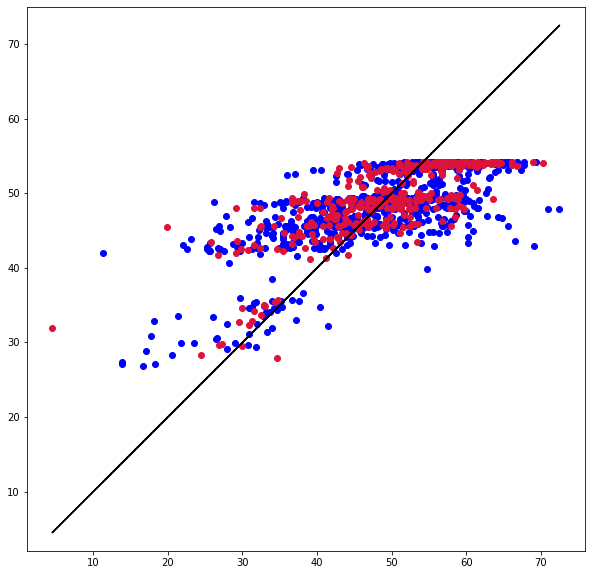

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.plot(train_csv["yield"], train_csv["yield"], c='black')
plt.plot(test_csv["yield"], test_csv["yield"], c='black')
plt.scatter(train_csv["yield"], pred_train, c='blue')
plt.scatter(test_csv["yield"], pred_test, c='crimson')
plt.axis('equal')

In [77]:
from scipy.stats import pearsonr
corr_train = pearsonr(train_csv["yield"], pred_train)
corr_test = pearsonr(test_csv["yield"], pred_test)

print("Train R2: ", corr_train)
print("Test R2: ", corr_test)

Train R2:  (array([0.7238722626926616], dtype=object), 9.100812015969943e-131)
Test R2:  (array([0.7540384106749141], dtype=object), 4.9160446528319886e-64)


# Visualize trees

In [66]:
!pip install tfgraphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py", line 385, in run
    conflicts = self

In [78]:
import tfgraphviz as tfg

In [82]:
tfdf.model_plotter.plot_model_in_colab(model_1, tree_idx=8)